# CAPSTONE PROJECT - REE Daily Generation Forecasting (Top-7 technologies)

1) Load the prepared panel dataset (unique_id, ds, y)
2) Time split into Train/Validation/Test (last 31 + 31 days)
3) Train and evaluate several model families:
    - Baselines (naive, moving average)
    - Statistical (AutoARIMA)
    - Machine Learning (MLForecast with different feature sets)
    - Deep Learning (NeuralForecast: NBEATS, NLinear)
4) Select best model per family on Validation (MAE)

5) Visualize performance on total generation (sum over technologies)
6) Fit the best overall (non-baseline if baseline wins) on all data
7) Forecast January 2026 + simple 95% prediction intervals
8) Save the metrics and predictions to /data/metrics and /data/predictions

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NLinear

In [3]:
H = 31 #forecast horizon for validation and test (31 days each)
TOP_K_SERIES = 7  #the top 7 technologies by mean daily generation
RANDOM_SEED = 4232

MOVING_AVG_WINDOW = 7  #baseline, the average of last 7 days
ARIMA_SEASON = 7 #weekly seasonality for daily data

# ML feature sets
ML_LAGS = [1, 2, 7, 14]
ML_DATE_FEATURES = ["dayofweek", "month", "day"]

# Neural models
NEURAL_INPUT_SIZE = 56
NEURAL_MAX_STEPS = 200

# Output folders
OUT_PRED_DIR = Path("data/predictions")
OUT_METRICS_DIR = Path("data/metrics")
OUT_PRED_DIR.mkdir(parents=True, exist_ok=True)
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def ope(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return (np.sum(np.abs(y_true - y_pred)) / (np.sum(y_true) + 1e-9)) * 100

def add_result(rows, unique_id, family, model, implementation, split, y_true, y_pred):
    # align lengths (safe and simple)
    n = min(len(y_true), len(y_pred))
    if n == 0:
        return

    y_true = np.asarray(y_true[:n])
    y_pred = np.asarray(y_pred[:n])

    r2 = r2_score(y_true, y_pred) if np.unique(y_true).size > 1 else np.nan

    rows.append({
        "unique_id": unique_id,
        "family": family,
        "model": model,
        "implementation": implementation,
        "split": split,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mape(y_true, y_pred),
        "OPE": ope(y_true, y_pred),
        "R2": r2,
    })

def evaluate_model(rows, unique_id, family, model, implementation,
                   y_val_true, y_val_pred, y_test_true, y_test_pred):
    add_result(rows, unique_id, family, model, implementation, "val",  y_val_true,  y_val_pred)
    add_result(rows, unique_id, family, model, implementation, "test", y_test_true, y_test_pred)

def best_model_per_family(val_results: pd.DataFrame) -> dict:
    best = {}
    for fam, g in val_results.groupby("family"):
        best[fam] = g.loc[g["MAE"].idxmin(), "model"]
    return best


# Load the prepared dataset
At first, there was 8 datasets(csv), 1 per year (2018-2025), but then I joined then and I preprocess the data:

We prepared the parquet file, is a clean panel with:
- columns [unique_id, ds, y]
- the top-7 technologies
- full daily date grid
- the missing values filled with (ffill/bfill)

In [5]:
PANEL_PATH = Path("data/processed/ree_panel_top7.parquet")

df_panel = pd.read_parquet(PANEL_PATH)
df_panel["ds"] = pd.to_datetime(df_panel["ds"])
df_panel = df_panel.sort_values(["unique_id", "ds"]).reset_index(drop=True)

print("Loaded panel:", df_panel.shape)
print("Series:", df_panel["unique_id"].nunique())
print("Date range:", df_panel["ds"].min(), "->", df_panel["ds"].max())
print("Unique IDs:", df_panel["unique_id"].unique())


Loaded panel: (20426, 3)
Series: 7
Date range: 2018-01-01 00:00:00 -> 2025-12-27 00:00:00
Unique IDs: ['Carbón' 'Ciclo combinado' 'Cogeneración' 'Eólica' 'Hidráulica' 'Nuclear'
 'Solar fotovoltaica']


# 3. Time split (Train/Validation/Test)

We use the last 31 days as Test, the previous 31 days as Validation and everything before that as Train


In [6]:
all_days = np.sort(df_panel["ds"].unique())
test_days  = all_days[-H:]
val_days   = all_days[-2 * H:-H]
train_days = all_days[:-2 * H]

df_train = df_panel[df_panel["ds"].isin(train_days)].copy()
df_val   = df_panel[df_panel["ds"].isin(val_days)].copy()
df_test  = df_panel[df_panel["ds"].isin(test_days)].copy()

print("Train:", df_train["ds"].min(),"->", df_train["ds"].max(), "n =", len(df_train))
print("Val:", df_val["ds"].min(),"->", df_val["ds"].max(),   "n =", len(df_val))
print("Test:", df_test["ds"].min(),"->", df_test["ds"].max(),  "n =", len(df_test))

Train: 2018-01-01 00:00:00 -> 2025-10-26 00:00:00 n = 19992
Val: 2025-10-27 00:00:00 -> 2025-11-26 00:00:00 n = 217
Test: 2025-11-27 00:00:00 -> 2025-12-27 00:00:00 n = 217


# 4. Model training and evaluation
For each technology (unique_id), we:
- Train models on Train
- Predict Validation
- Train on Train+Val
- Predict Test
- Store all metrics in a table for comparison

In [7]:
results = []
unique_ids = df_panel["unique_id"].unique()

#Baselines
for uid in unique_ids:
    dm = df_panel[df_panel["unique_id"] == uid].sort_values("ds")

    y_train = dm[dm["ds"].isin(train_days)]["y"].values
    y_val_true  = dm[dm["ds"].isin(val_days)]["y"].values
    y_test_true = dm[dm["ds"].isin(test_days)]["y"].values

    #naive: last value
    y_val_pred = np.repeat(y_train[-1], len(y_val_true))
    y_test_pred = np.repeat(y_val_true[-1], len(y_test_true))
    evaluate_model(
        results,
        uid, "baseline", 
        "naive", 
        "numpy",
        y_val_true, 
        y_val_pred, 
        y_test_true, 
        y_test_pred)

    # moving average: mean of the last 7 train values and for Test, use last 7 Val values
    w = min(MOVING_AVG_WINDOW, len(y_train))
    y_val_pred = np.repeat(np.mean(y_train[-w:]), len(y_val_true))

    w2 = min(MOVING_AVG_WINDOW, len(y_val_true))
    y_test_pred = np.repeat(np.mean(y_val_true[-w2:]), len(y_test_true))

    evaluate_model(
        results, 
        uid, 
        "baseline", 
        f"moving_avg_{MOVING_AVG_WINDOW}",
        "numpy",
        y_val_true,
        y_val_pred,
        y_test_true,
        y_test_pred)

#2 AutoARIMA (StatsForecast)
sf = StatsForecast(
    models=[AutoARIMA(season_length=ARIMA_SEASON, stepwise=True, approximation=True)],
    freq="D",
)

#fit on train -> predict Validation
sf.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_arima = sf.predict(h=H)

df_train_val = df_panel[df_panel["ds"].isin(np.concatenate([train_days, val_days]))].copy()

#fit on Train+Val -> predict Test
sf.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_arima = sf.predict(h=H)

for uid in unique_ids:
    y_val_true  = df_val[df_val["unique_id"] == uid].sort_values("ds")["y"].values
    y_test_true = df_test[df_test["unique_id"] == uid].sort_values("ds")["y"].values

    pv = preds_val_arima[preds_val_arima["unique_id"] == uid].sort_values("ds")["AutoARIMA"].values
    pt = preds_test_arima[preds_test_arima["unique_id"] == uid].sort_values("ds")["AutoARIMA"].values

    evaluate_model(
        results, 
        uid, 
        "statistical", 
        "AutoARIMA",
        "statsforecast",
        y_val_true,
        pv, 
        y_test_true,
        pt)


c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spa

In [8]:
#3 MLForecast
# we test 3 feature sets:
# lags only, 
# lags + calendar features (dayofweek/month/day)
# lags + statistical transforms (rolling mean, expanding mean)

ml_models = [
    RandomForestRegressor(n_estimators=600, random_state=RANDOM_SEED),
    GradientBoostingRegressor(random_state=RANDOM_SEED),
]

# lag
fcst_lag = MLForecast(
    models=ml_models, 
    freq="D", 
    lags=ML_LAGS)

fcst_lag.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_ml_lag = fcst_lag.predict(h=H)

fcst_lag.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_ml_lag = fcst_lag.predict(h=H)

# lag + calendar
fcst_cal = MLForecast(
    models=ml_models, 
    freq="D", 
    lags=ML_LAGS, 
    date_features=ML_DATE_FEATURES)

fcst_cal.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_ml_cal = fcst_cal.predict(h=H)

fcst_cal.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_ml_cal = fcst_cal.predict(h=H)

# lag + statistical 
lag_transforms = {
    1:  [ExpandingMean()],
    7:  [RollingMean(window_size=7)],
    14: [RollingMean(window_size=14)],
}
fcst_stat = MLForecast(
    models=ml_models, 
    freq="D", 
    lags=ML_LAGS, 
    lag_transforms=lag_transforms)

fcst_stat.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_ml_stat = fcst_stat.predict(h=H)

fcst_stat.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_ml_stat = fcst_stat.predict(h=H)

ml_pred_sets = [
    ("lag", preds_val_ml_lag, preds_test_ml_lag),
    ("lag+calendar", preds_val_ml_cal, preds_test_ml_cal),
    ("lag+statistical", preds_val_ml_stat, preds_test_ml_stat),
]
ml_model_names = ["RandomForestRegressor", "GradientBoostingRegressor"]

for uid in unique_ids:
    y_val_true  = df_val[df_val["unique_id"] == uid].sort_values("ds")["y"].values
    y_test_true = df_test[df_test["unique_id"] == uid].sort_values("ds")["y"].values

    for fset, pv_df, pt_df in ml_pred_sets:
        pv = pv_df[pv_df["unique_id"] == uid].sort_values("ds")
        pt = pt_df[pt_df["unique_id"] == uid].sort_values("ds")

        for mname in ml_model_names:
            
            evaluate_model(
                results,
                uid, 
                "ml",
                f"{mname}__{fset}", 
                "mlforecast_sklearn",
                y_val_true, 
                pv[mname].values, 
                y_test_true, 
                pt[mname].values
            )

In [9]:
#4 NeuralForecast (NBEATS + NLinear)
dl_models = [
    NBEATS(h=H, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
    NLinear(h=H, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
]
nf = NeuralForecast(models=dl_models, freq="D")

nf.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_dl = nf.predict()

nf.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_dl = nf.predict()

for uid in unique_ids:
    y_val_true  = df_val[df_val["unique_id"] == uid].sort_values("ds")["y"].values
    y_test_true = df_test[df_test["unique_id"] == uid].sort_values("ds")["y"].values

    pv = preds_val_dl[preds_val_dl["unique_id"] == uid].sort_values("ds")
    pt = preds_test_dl[preds_test_dl["unique_id"] == uid].sort_values("ds")

    for mname in ["NBEATS", "NLinear"]:
        evaluate_model(
            results, 
            uid,
            "neural",
            mname,
            "neuralforecast",
            y_val_true, 
            pv[mname].values, 
            y_test_true, 
            pt[mname].values)



Seed set to 4232
Seed set to 4232
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
5.5 K     Non-trainable params
2.6 M     Total params
10.265    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, v_num=0, train_loss_step=21.60, train_loss_epoch=21.60]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, v_num=0, train_loss_step=21.60, train_loss_epoch=21.60]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 1.8 K  | train
-------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s, v_num=1, train_loss_step=27.40, train_loss_epoch=27.40] 

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s, v_num=1, train_loss_step=27.40, train_loss_epoch=27.40]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.32it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.82it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
5.5 K     Non-trainable params
2.6 M     Total params
10.265    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode



Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s, v_num=4, train_loss_step=21.00, train_loss_epoch=21.00]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s, v_num=4, train_loss_step=21.00, train_loss_epoch=21.00]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 1.8 K  | train
-------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s, v_num=5, train_loss_step=26.60, train_loss_epoch=26.60] 

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s, v_num=5, train_loss_step=26.60, train_loss_epoch=26.60]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.93it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.93it/s]


# Result table and Model selection
We save: 
- metrics_all.csv: one row per technology, mocel, split
- metrics_summary.csv: avverage metrics per model family/split
Model choice:
- Best per family = lowest MAE on Validation
- Best overall = lowest average MAE on validation across technologies

In [10]:

results_df = pd.DataFrame(results)
results_df.to_csv(OUT_METRICS_DIR / "metrics_all.csv", index=False)

summary_df = (
    results_df.groupby(["family", "model", "implementation", "split"], as_index=False)
    .agg({"MAE": "mean", "RMSE": "mean", "MAPE": "mean", "OPE": "mean", "R2": "mean"})
)
summary_df.to_csv(OUT_METRICS_DIR / "metrics_summary.csv", index=False)

val_results = results_df[results_df["split"] == "val"].copy()
best_models = best_model_per_family(val_results)

print("Best per family (by MAE on validation):")
print(best_models)

avg_val = (
    val_results.groupby(["family", "model", "implementation"], as_index=False)
    .agg({"MAE": "mean"})
    .sort_values("MAE")
)
best_overall = avg_val.iloc[0]

# if a baseline is the best, we choose the non-baseline to the final forecast because is more realistic
if best_overall["family"] == "baseline":
    best_overall = avg_val[avg_val["family"] != "baseline"].iloc[0]
    print("Final model (non-baseline):", dict(best_overall))

print("Best OVERALL:", dict(best_overall))


Best per family (by MAE on validation):
{'baseline': 'naive', 'ml': 'RandomForestRegressor__lag+statistical', 'neural': 'NBEATS', 'statistical': 'AutoARIMA'}
Final model (non-baseline): {'family': 'ml', 'model': 'RandomForestRegressor__lag+calendar', 'implementation': 'mlforecast_sklearn', 'MAE': 26.137885341159745}
Best OVERALL: {'family': 'ml', 'model': 'RandomForestRegressor__lag+calendar', 'implementation': 'mlforecast_sklearn', 'MAE': 26.137885341159745}


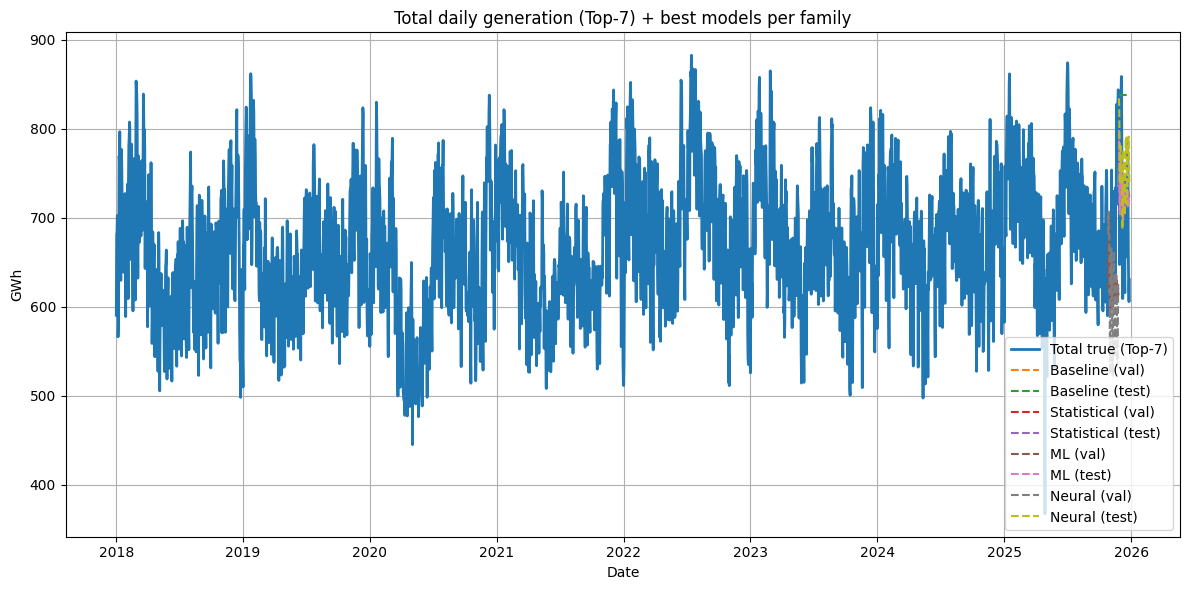

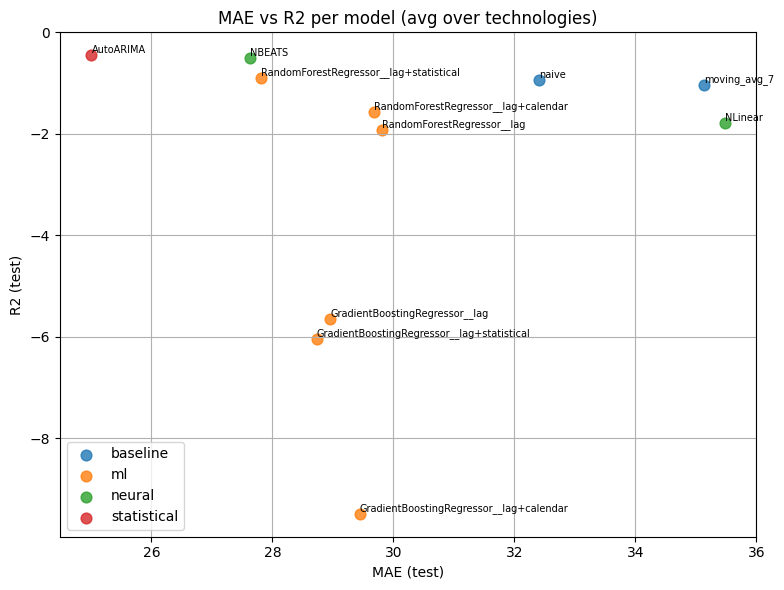

In [11]:
#7) Visuals 
total_series = df_panel.groupby("ds")["y"].sum()
total_train = total_series[total_series.index.isin(train_days)]
total_val   = total_series[total_series.index.isin(val_days)]
total_test  = total_series[total_series.index.isin(test_days)]

val_dates  = total_val.index.values
test_dates = total_test.index.values

# compose total predictions for best model per family 
total_pred_val = {}
total_pred_test = {}

# baseline
b = best_models.get("baseline", None)
if b == "naive":
    total_pred_val["baseline"]  = np.repeat(total_train.values[-1], len(val_dates))
    total_pred_test["baseline"] = np.repeat(total_val.values[-1], len(test_dates))
elif b is not None:
    total_pred_val["baseline"]  = np.repeat(total_train.values[-MOVING_AVG_WINDOW:].mean(), len(val_dates))
    total_pred_test["baseline"] = np.repeat(total_val.values[-MOVING_AVG_WINDOW:].mean(), len(test_dates))

# statistical
if "statistical" in best_models:
    total_pred_val["statistical"]  = preds_val_arima.groupby("ds")[best_models["statistical"]].sum().values
    total_pred_test["statistical"] = preds_test_arima.groupby("ds")[best_models["statistical"]].sum().values

# ml
if "ml" in best_models:
    col = best_models["ml"]
    base_model = col.split("__")[0]
    if "__lag+calendar" in col:
        pv_df, pt_df = preds_val_ml_cal, preds_test_ml_cal
    elif "__lag+statistical" in col:
        pv_df, pt_df = preds_val_ml_stat, preds_test_ml_stat
    else:
        pv_df, pt_df = preds_val_ml_lag, preds_test_ml_lag

    total_pred_val["ml"]  = pv_df.groupby("ds")[base_model].sum().values
    total_pred_test["ml"] = pt_df.groupby("ds")[base_model].sum().values

# neural
if "neural" in best_models:
    col = best_models["neural"]
    total_pred_val["neural"]  = preds_val_dl.groupby("ds")[col].sum().values
    total_pred_test["neural"] = preds_test_dl.groupby("ds")[col].sum().values

plt.figure(figsize=(12, 6))
plt.plot(total_series.index, total_series.values, label="Total true (Top-7)", linewidth=2)

name_map = {"baseline": "Baseline", "statistical": "Statistical", "ml": "ML", "neural": "Neural"}
for fam in ["baseline", "statistical", "ml", "neural"]:
    if fam in total_pred_val:
        plt.plot(val_dates, total_pred_val[fam], "--", label=f"{name_map[fam]} (val)")
        plt.plot(test_dates, total_pred_test[fam], "--", label=f"{name_map[fam]} (test)")

plt.title("Total daily generation (Top-7) + best models per family")
plt.xlabel("Date")
plt.ylabel("GWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE vs R2 scatter (test)
test_results = results_df[results_df["split"] == "test"].copy()
agg = test_results.groupby(["family", "model"], as_index=False).agg({"MAE": "mean", "R2": "mean"})

plt.figure(figsize=(8, 6))
for fam in agg["family"].unique():
    sub = agg[agg["family"] == fam]
    plt.scatter(sub["MAE"], sub["R2"], label=fam, s=60, alpha=0.8)
    for _, row in sub.iterrows():
        plt.text(row["MAE"], row["R2"], row["model"], fontsize=7, ha="left", va="bottom")

plt.xlabel("MAE (test)")
plt.ylabel("R2 (test)")
plt.title("MAE vs R2 per model (avg over technologies)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

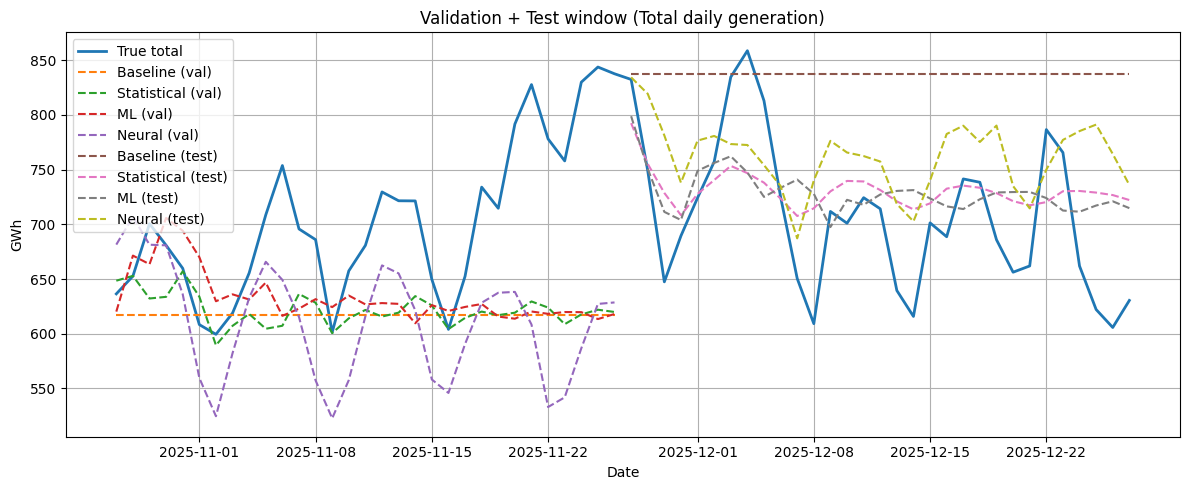

In [12]:
#Plot only VAL + TEST (total)
total = df_panel.groupby("ds")["y"].sum()

plot_start = pd.to_datetime(val_days[0])
plot_end   = pd.to_datetime(test_days[-1])

val_dates  = pd.to_datetime(val_days)
test_dates = pd.to_datetime(test_days)

plt.figure(figsize=(12,5))

plt.plot(total.loc[plot_start:plot_end], label="True total", linewidth=2)

# Predictions (best per family) only in val+test to see better
name_map = {"baseline":"Baseline", "statistical":"Statistical", "ml":"ML", "neural":"Neural"}

for fam in total_pred_val:
    plt.plot(val_dates, total_pred_val[fam], "--", label=f"{name_map.get(fam,fam)} (val)")

for fam in total_pred_test:
    plt.plot(test_dates, total_pred_test[fam], "--", label=f"{name_map.get(fam,fam)} (test)")

plt.title("Validation + Test window (Total daily generation)")
plt.xlabel("Date"); plt.ylabel("GWh")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

In [13]:
#Forecast Jan 2026 (best overall) + simple uncertainty

df_all = df_panel.copy()
last_date = df_all["ds"].max()

jan_start = pd.Timestamp("2026-01-01")
jan_end   = pd.Timestamp("2026-01-31")

#forecast horizon must cover until Jan 31
h_total = max(1, (jan_end - last_date).days)

family = best_overall["family"]
model_name = best_overall["model"]

#helper: residual quantiles from validation (simple PI)
def residual_quantiles_from_val(family, model_name):
    # merge df_val with predictions for the selected model
    if family == "statistical":
        preds = preds_val_arima.rename(columns={"AutoARIMA": "yhat"})[["unique_id", "ds", "yhat"]]
    elif family == "ml":
        base_model = model_name.split("__")[0]
        if "__lag+calendar" in model_name:
            pv_df = preds_val_ml_cal
        elif "__lag+statistical" in model_name:
            pv_df = preds_val_ml_stat
        else:
            pv_df = preds_val_ml_lag
        preds = pv_df.rename(columns={base_model: "yhat"})[["unique_id", "ds", "yhat"]]
    elif family == "neural":
        preds = preds_val_dl.rename(columns={model_name: "yhat"})[["unique_id", "ds", "yhat"]]
    else:
        res = []
        for uid in unique_ids:
            dm = df_all[df_all["unique_id"] == uid].sort_values("ds")
            y_train = dm[dm["ds"].isin(train_days)]["y"].values
            yv = dm[dm["ds"].isin(val_days)]["y"].values

            if "moving_avg" in model_name:
                w = min(MOVING_AVG_WINDOW, len(y_train))
                yhat = np.repeat(np.mean(y_train[-w:]), len(yv))
            else:
                yhat = np.repeat(y_train[-1], len(yv))

            res.append(yv - yhat)

        res = np.concatenate(res)
        return np.quantile(res, 0.025), np.quantile(res, 0.975)

    merged = df_val.merge(preds, on=["unique_id", "ds"], how="inner")
    res = (merged["y"] - merged["yhat"]).values
    return np.quantile(res, 0.025), np.quantile(res, 0.975)

q_lo, q_hi = residual_quantiles_from_val(family, model_name)

#Fit best overall on all data and forecast 
if family == "statistical":
    sf_final = StatsForecast(models=[AutoARIMA(season_length=ARIMA_SEASON)], freq="D")
    sf_final.fit(df_all, id_col="unique_id", time_col="ds", target_col="y")
    fcst = sf_final.predict(h=h_total).rename(columns={"AutoARIMA": "yhat"})
    out_fcst = fcst[["unique_id", "ds", "yhat"]].copy()

elif family == "ml":
    base_model = model_name.split("__")[0]

    if "__lag+calendar" in model_name:
        final_fcst = MLForecast(models=ml_models, freq="D", lags=ML_LAGS, date_features=ML_DATE_FEATURES)
    elif "__lag+statistical" in model_name:
        final_fcst = MLForecast(models=ml_models, freq="D", lags=ML_LAGS, lag_transforms=lag_transforms)
    else:
        final_fcst = MLForecast(models=ml_models, freq="D", lags=ML_LAGS)

    final_fcst.fit(df_all, id_col="unique_id", time_col="ds", target_col="y")
    pred = final_fcst.predict(h=h_total)
    out_fcst = pred.rename(columns={base_model: "yhat"})[["unique_id", "ds", "yhat"]].copy()

elif family == "neural":
    dl_models_final = [
        NBEATS(h=h_total, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
        NLinear(h=h_total, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
    ]
    nf_final = NeuralForecast(models=dl_models_final, freq="D")
    nf_final.fit(df_all, id_col="unique_id", time_col="ds", target_col="y")
    pred = nf_final.predict()
    out_fcst = pred.rename(columns={model_name: "yhat"})[["unique_id", "ds", "yhat"]].copy()

else:
    # baseline forecast: repeat last observed value
    rows = []
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=h_total, freq="D")
    for uid in unique_ids:
        y_last = df_all[df_all["unique_id"] == uid].sort_values("ds")["y"].values[-1]
        for d in future_dates:
            rows.append({"unique_id": uid, "ds": d, "yhat": y_last})
    out_fcst = pd.DataFrame(rows)

# keep only Jan 2026
out_fcst["ds"] = pd.to_datetime(out_fcst["ds"])
out_fcst = out_fcst[(out_fcst["ds"] >= jan_start) & (out_fcst["ds"] <= jan_end)].copy()

# add simple prediction interval (empirical residuals from validation)
out_fcst["yhat_lo_95"] = (out_fcst["yhat"] + q_lo).clip(lower=0)
out_fcst["yhat_hi_95"] = (out_fcst["yhat"] + q_hi).clip(lower=0)

csv_path = OUT_PRED_DIR / "forecast_best_overall_jan2026.csv"
out_fcst.to_csv(csv_path, index=False)


pq_path = OUT_PRED_DIR / "forecast_best_overall_jan2026.parquet"
out_fcst.to_parquet(pq_path, index=False)
print("Saved:", csv_path, "and", pq_path)

print(out_fcst.head(10))

Saved: data\predictions\forecast_best_overall_jan2026.csv and data\predictions\forecast_best_overall_jan2026.parquet
   unique_id         ds      yhat  yhat_lo_95  yhat_hi_95
4     Carbón 2026-01-01  3.248765         0.0  173.348672
5     Carbón 2026-01-02  3.174333         0.0  173.274241
6     Carbón 2026-01-03  2.212674         0.0  172.312581
7     Carbón 2026-01-04  1.877636         0.0  171.977544
8     Carbón 2026-01-05  2.638372         0.0  172.738280
9     Carbón 2026-01-06  3.943946         0.0  174.043854
10    Carbón 2026-01-07  4.193762         0.0  174.293669
11    Carbón 2026-01-08  4.205890         0.0  174.305798
12    Carbón 2026-01-09  4.306591         0.0  174.406498
13    Carbón 2026-01-10  4.199306         0.0  174.299213
